### This notebook runs FlowSOM pixel-level clustering

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import numpy as np
import pandas as pd
import xarray as xr

from ark.phenotyping import som_utils
from ark.utils import io_utils, load_utils

### Set file paths and parameters

In [ ]:
# assign data file paths
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = "../data/granulomaCohort_allData"

In [ ]:
# define the SOM preprocessed and subsetted path
preprocessed_dir = 'pixel_mat_preprocessed'
subsetted_dir = 'pixel_mat_subsetted'

In [ ]:
# set mibitiff parameters
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["Point14"]

### Preprocess

In [ ]:
# set the channels to subset over
channels = ["CD45", "SMA", "Vimentin", "CD31", "Keratin-pan", "E-cadherin", "MastChyTry",
            "MPO", "CD20", "CD3", "CD14", "HLA-DR-DQ-DP", "Foxp3", "CD16", "CD11c", "CD206",
            "CD11b", "CD68", "CD163", "CD209"]

In [ ]:
# run FlowSOM preprocessing
som_utils.create_pixel_matrix(
    fovs, channels, base_dir, tiff_dir, segmentation_dir, pre_dir=preprocessed_dir, sub_dir=subsetted_dir,
)

### Train pixel SOM

In [ ]:
# define the pixel SOM cluster, consensus cluster paths, and pixel SOM weights paths, explicitly set the variables to use custom names
pixel_clustered_dir = None
pixel_consensus_dir = None
pixel_weights_name = None

# get the current time for separating different runs
cur_time = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

if pixel_clustered_dir is None:
    pixel_clustered_dir = 'pixel_mat_clustered_%s' % cur_time

if pixel_consensus_dir is None:
    pixel_consensus_dir = 'pixel_mat_consensus_%s' % cur_time
    
if pixel_weights_name is None:
    pixel_weights_name = 'pixel_weights_%s.feather' % cur_time

In [ ]:
# create the pixel-level SOM weights
som_utils.train_pixel_som(fovs, channels, base_dir, sub_dir=subsetted_dir, weights_name=pixel_weights_name)

### Assign pixel SOM clusters

In [ ]:
# use pixel SOM weights to assign pixel clusters
som_utils.cluster_pixels(fovs, base_dir, pre_dir=preprocessed_dir, weights_name=pixel_weights_name, cluster_dir=pixel_clustered_dir)

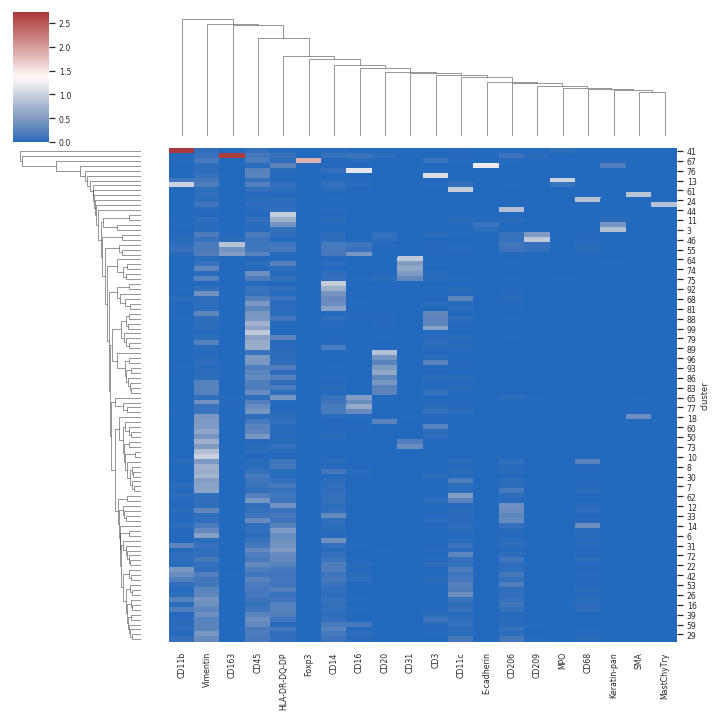

In [11]:
# visualize the pixel cluster average heatmap
som_utils.visualize_pixel_cluster_data(
    fovs, channels, base_dir, cluster_dir=pixel_clustered_dir, pixel_cluster_col='cluster'
)

### Run pixel consensus clustering

In [ ]:
# run hierarchical clustering based on pixel SOM cluster assignments
som_utils.pixel_consensus_cluster(
    fovs, channels, base_dir, cluster_dir=pixel_clustered_dir, consensus_dir=pixel_consensus_dir
)

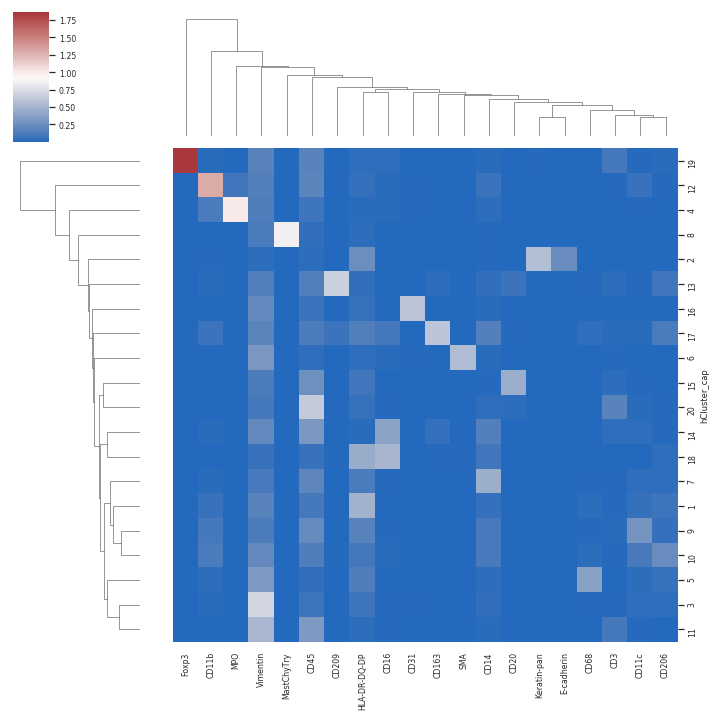

In [13]:
# visualize the pixel hierarchical cluster average heatmap
som_utils.visualize_pixel_cluster_data(
    fovs, channels, base_dir, cluster_dir=pixel_consensus_dir, pixel_cluster_col='hCluster_cap'
)

### Train cell SOM

In [ ]:
# path to cell table (created by Segment_Image_Data.ipynb)
cell_table_name = 'cell_table_size_normalized.csv'

In [ ]:
# define the cell SOM cluster and cell SOM weights paths, explicitly set the variables to use custom names
cell_clustered_name = None
cell_consensus_name = None
cell_weights_name = None

if cell_clustered_name is None:
    cell_clustered_name = 'cell_mat_clustered_%s.feather' % cur_time
    
if cell_consensus_name is None:
    cell_consensus_name = 'cell_mat_consensus_%s.feather' % cur_time
    
if cell_weights_name is None:
    cell_weights_name = 'cell_weights_%s.feather' % cur_time

In [ ]:
# create the cell-level SOM weights
som_utils.train_cell_som(fovs, base_dir, cell_table_name=cell_table_name, pixel_consensus_dir=pixel_consensus_dir, cluster_col='cluster', weights_name=cell_weights_name)

### Assign cell SOM clusters

In [ ]:
# use cell SOM weights to assign cell clusters
som_utils.cluster_cells(base_dir, weights_name=cell_weights_name, cell_cluster_name=cell_clustered_name)

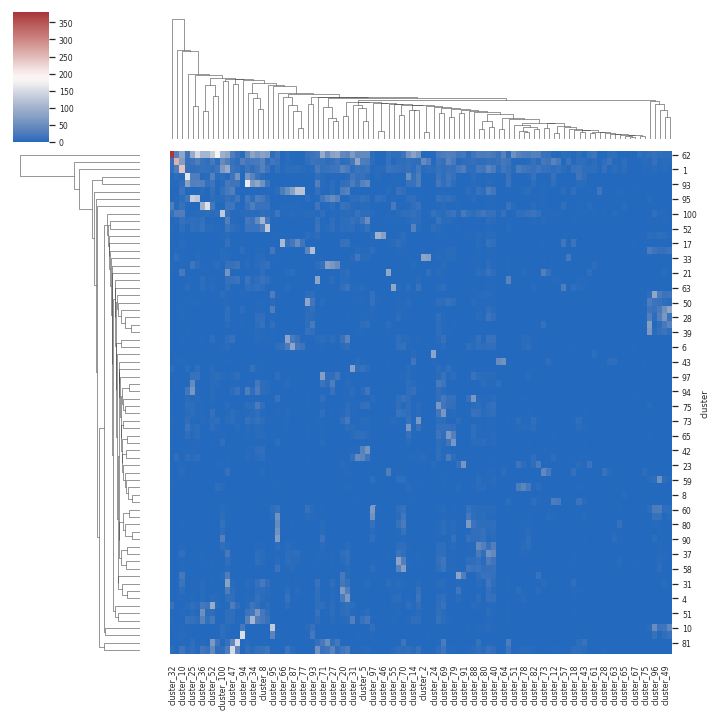

In [18]:
# visualize the cell SOM cluster average heatmap
som_utils.visualize_cell_cluster_data(
    base_dir, cluster_name=cell_clustered_name, column_prefix='cluster', cell_cluster_col='cluster'
)

### Run cell consensus clustering

In [ ]:
# run hierarchical clustering based on cell SOM cluster assignments
som_utils.cell_consensus_cluster(
    base_dir=base_dir, cell_cluster_name=cell_clustered_name, column_prefix='cluster', cell_consensus_name=cell_consensus_name
)

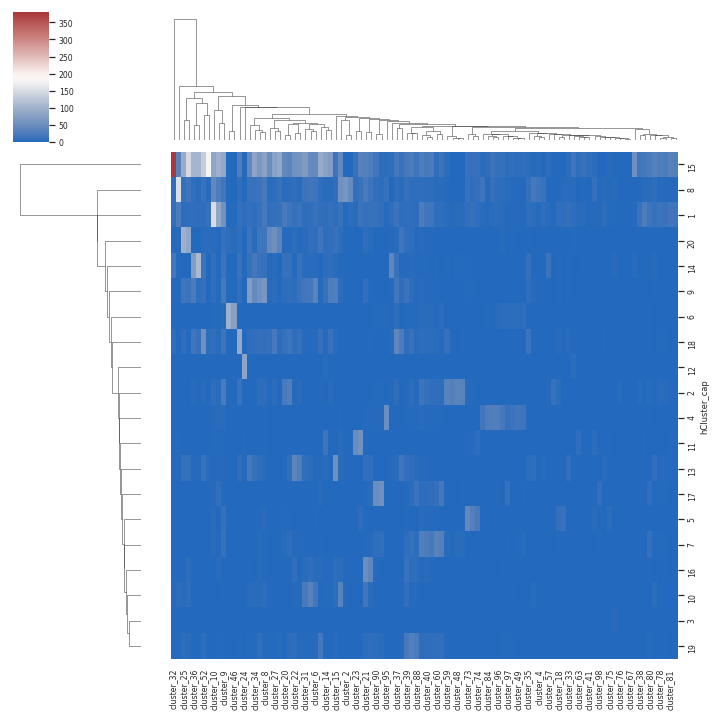

In [20]:
# visualize the cell hierarchical cluster average heatmap
som_utils.visualize_cell_cluster_data(
    base_dir, cluster_name=cell_consensus_name, column_prefix='cluster', cell_cluster_col='hCluster_cap'
)